# Sort  CSpine & LSpine Xrays with Fastai

- CSpine: frontal, lateral, oblique
- LSpine: frontal, lateral
- 250 images sorted by A. Stein, MD Radiology

### Original images from: 

### VinDr-SpineXR: An open dataset for spinal lesions detection and classification from radiographs

```Hieu T. Nguyen, Hieu H. Pham, Nghia T. Nguyen, Ha Q. Nguyen, Thang Q. Huynh, Minh Dao, and Van Vu, “VinDr-SpineXR: A deep learning framework for spinal lesions detection and classification from radiographs,” in Proceedings of the 2021 International Conference on Medical Image Computing and Computer Assisted Intervention (MICCAI 2021)```

In [43]:
from fastai.vision.all import *
from fastai.medical.imaging import *
from fastcore.all import *
import pandas as pd
import pydicom
#import timm

import os
import shutil

import heapq

import warnings
warnings.filterwarnings('ignore')

## Enhancement to fastai's PILDicom - Applies metadata values to DCM

In [44]:
class PILDicom2(PILBase):
    _open_args,_tensor_cls,_show_args = {},TensorDicom,TensorDicom._show_args
    @classmethod
    def create(cls, fn:(Path,str,bytes), mode=None)->None:
        "Open a `DICOM file` from path `fn` or bytes `fn` and load it as a `PIL Image`"
        if isinstance(fn,bytes): im = Image.fromarray(dcmread_to8bit(pydicom.filebase.DicomBytesIO(fn)))
        if isinstance(fn,(Path,str)): im = Image.fromarray(dcmread_to8bit(fn))
        im.load()
        im = im._new(im.im)
        return cls(im.convert(mode) if mode else im)
    
    
def get_window_from_dicom(dicom_file):
    """
    Returns window width and window center values or first example if MultiValue
    Strips comma from value if present
    If no window width/level is provided or available, returns None.
    """
    width, level = None, None
    try:
        if "WindowWidth" in dicom_file:
            width = dicom_file.WindowWidth
            if isinstance(width, pydicom.multival.MultiValue):
                width = float(width[0])
            else:
                width = float(str(width).replace(',', ''))
    except:
        print(dicom_file.WindowWidth)

    if "WindowCenter" in dicom_file:
        level = dicom_file.WindowCenter
        if isinstance(level, pydicom.multival.MultiValue):
            level = float(level[0])
        else:
            level = float(str(level).replace(',', ''))
    return width, level


def dcmread_to8bit(fn):
    """
    Returns 8 bit array from dicom file
    Applies Intercept/Slope and Window Center/Width
    Scales to 255
    Inverts if MONOCHROME1
    """
    dcm = Path(fn).dcmread()
    arr=dcm.pixel_array
    
    #slope, intercept
    slope = 1
    intercept = 0
    if "RescaleIntercept" in dcm and "RescaleSlope" in dcm:
        intercept = int(dcm.RescaleIntercept)
        slope = int(dcm.RescaleSlope)
        
    arr = intercept + arr * slope
    
    #window
    width,level = get_window_from_dicom(dcm)
    if width is not None and level is not None:
        arr = np.clip(arr, level - width // 2, level + width // 2)
        
    #scale
    arr = (arr - np.min(arr)) / np.max(arr)
    arr = (arr * 255).astype("uint8")
    
    if "PhotometricInterpretation" in dcm and dcm.PhotometricInterpretation == "MONOCHROME1":
        arr = 255 - arr
        
    return arr

In [45]:
ROOT = Path("/Users/anouk/Developer/Data/vindr-spinexr-a-large-annotated-medical-image-dataset-for-spinal-lesions-detection-and-classification-from-radiographs-1.0.0/")
# all images
all_images_path = ROOT/'train_images'
all_images = get_dicom_files(all_images_path)

# labeled data
sorted_images_path = Path(ROOT/"sorted")
images = get_dicom_files(sorted_images_path)

len(images), images[0]

(250,
 Path('/Users/anouk/Developer/Data/vindr-spinexr-a-large-annotated-medical-image-dataset-for-spinal-lesions-detection-and-classification-from-radiographs-1.0.0/sorted/cspine/frontal/fc81f77a14189e9b37b7f77018434020.dicom'))

## Create dataframe from labeled folders

In [46]:
df = pd.DataFrame()
for fn in images:
    df = df.append({'fn':fn.stem, 'bodypart':str(fn).split('/')[-3], 'position': str(fn).split('/')[-2]},ignore_index=True)
    df['labels'] = [[item.bodypart,  item.position] for _,item in df.iterrows()]
df.head()

,fn,bodypart,position,labels
0,fc81f77a14189e9b37b7f77018434020,cspine,frontal,"[cspine, frontal]"
1,0a673966107de697fad89dbd15ed83a6,cspine,frontal,"[cspine, frontal]"
2,fe680671af024121e99aa4ddf4e2c94b,cspine,frontal,"[cspine, frontal]"
3,0bd9e98588316bdaa5de38146d2ce2b0,cspine,frontal,"[cspine, frontal]"
4,faaed6874df5ea193c886acc5fcfe751,cspine,frontal,"[cspine, frontal]"


In [58]:
df.to_csv('labeled_data.csv')

In [50]:
df.position.value_counts()

frontal    109
lateral    101
oblique     40
Name: position, dtype: int64

In [51]:
df.bodypart.value_counts()

cspine    143
lspine    107
Name: bodypart, dtype: int64

## Dataloader

- specialized ImageBlock (PILDicom2)
- MultiCategoryBlock
- getters to read image and labels from dataframe
- pad mode used

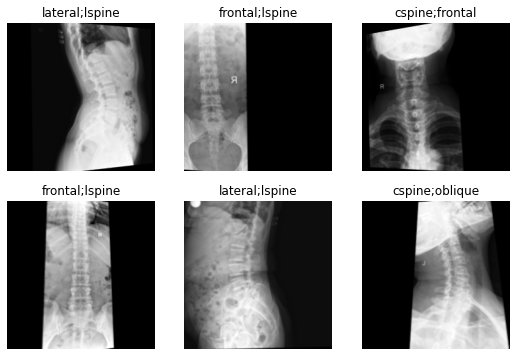

In [52]:
dls = DataBlock(
    blocks=(ImageBlock(cls=PILDicom2), MultiCategoryBlock), 
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    getters=[ColReader('fn', pref=all_images_path, suff='.dicom'),   # image input
        ColReader('labels')],      
     batch_tfms= [*aug_transforms(size=224, pad_mode=PadMode.Zeros)],
    item_tfms=[Resize(192, method='pad',pad_mode=PadMode.Zeros)]
).dataloaders(df, bs=12)
dls.show_batch(max_n=6)

In [53]:
dls.vocab

['cspine', 'frontal', 'lateral', 'lspine', 'oblique']

In [10]:
learn = vision_learner(dls, resnet34, metrics=[partial(accuracy_multi, thresh=0.5)]).to_fp16()
learn.fine_tune(10)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.832435,0.509821,0.792000,00:28


epoch,train_loss,valid_loss,accuracy_multi,time
0,0.420998,0.371937,0.888000,00:41
1,0.347227,0.184172,0.936000,00:43
2,0.294470,0.077243,0.992000,00:42
3,0.260249,0.050838,0.992000,00:42
4,0.228337,0.036645,0.992000,00:44
5,0.196722,0.018431,1.000000,00:41
6,0.161001,0.020072,1.000000,00:40
7,0.135757,0.013838,1.000000,00:42
8,0.124615,0.012863,1.000000,00:43
9,0.102849,0.014202,1.000000,00:47


## Predict

In [11]:
#Images for prediction
predict_folder = ROOT/'train_images'
predict_fn =  get_dicom_files(predict_folder)

#remove images used for training
item_names = [i.name for i in items]
predict_fn = [i for i in predict_fn if i.name not in item_names]

#Test dataloader
test_dl = learn.dls.test_dl(predict_fn[:300])

#add tta
tta,_ = learn.tta(dl=test_dl)

## Create dataframe from predictions

In [22]:
pr = tta > 0.5

predict_df = pd.DataFrame()
for i,p in enumerate(pr):
    #print(p)
    labels = learn.dls.vocab[p]

    #If three predictions, take 2 most confident
    #Predictions with 1 or 4 labels will be classified as unknown
    if len(labels) == 3:
        idx = heapq.nlargest(2, np.array(tta[i]))
        first = list(tta[i]).index(idx[0])
        second = list(tta[i]).index(idx[1])
        labels = [learn.dls.vocab[first], learn.dls.vocab[second]]
        
    num = len(labels)
        
    predict_df = predict_df.append({'fn':predict_fn[i].name,'labels':labels, 'preds':np.array(tta[i]), 'number':num}, ignore_index=True)
predict_df.head()    

,fn,labels,preds,number
0,f4d9ac52b7671454ff59eb233728af7d.dicom,"[cspine, lateral]","[0.9963759, 0.005022919, 0.9893314, 0.013453374, 0.19751549]",2
1,1d5365ca503f3a9ac3f57f9aa27db331.dicom,"[lateral, lspine]","[0.001378062, 0.025749931, 0.99906945, 0.9976482, 0.017999716]",2
2,1d4ebb4ccfc62bdb214b7d9839f91326.dicom,"[lateral, lspine]","[0.00030093215, 0.00020149835, 0.99999475, 0.9998481, 0.118455246]",2
3,0e5ecf77c71d2ca5907cae6040e916fd.dicom,"[lateral, lspine]","[0.07562894, 0.2304861, 0.88543963, 0.9231672, 0.022941176]",2
4,60f85af5f3e1e36872e2da6adddd8564.dicom,"[lateral, lspine]","[0.00010145149, 0.00024555286, 0.9999847, 0.99994034, 0.11291027]",2


In [54]:
predict_df.number.value_counts()

2    296
1      4
Name: number, dtype: int64

## Show unknown prediction values

### We see that most are thoracic images that should not be in the prediction dataset

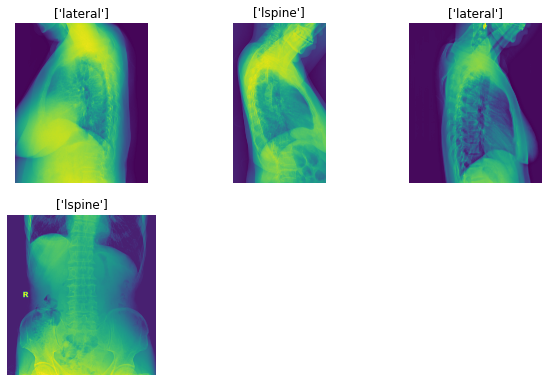

In [55]:
abn = predict_df[predict_df.number != 2].reset_index()

# set the canvas size in inches
plt.figure(figsize=(10,10))

for i, row in abn.iterrows():
  plt.subplot(3,3,i+1)    
  img =img = dcmread_to8bit(predict_folder/row.fn)
  plt.imshow(img)
  plt.title(row.labels)
  plt.axis("off")

plt.show()
plt.close()

## View sample predictions

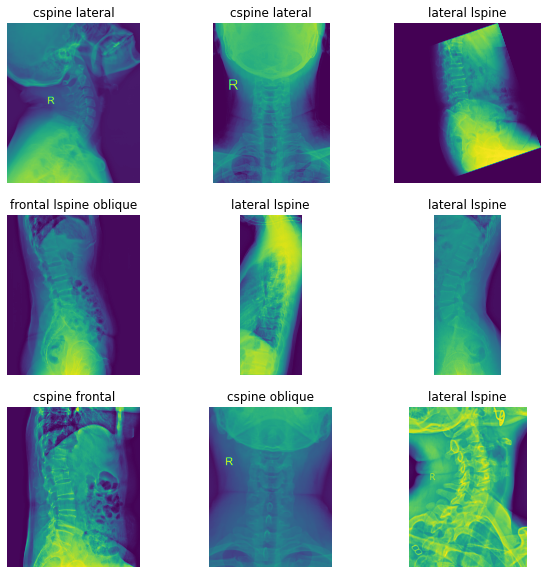

In [84]:
images = predict_df.fn.values[:9]

# set the canvas size in inches
plt.figure(figsize=(10,10))

for i, img_path in enumerate(images):
  
  # the number of images in the grid is 3*3 (9)
  plt.subplot(3,3,i+1)    
  img = dcmread2(src_folder/img_path)
  plt.imshow(img)
  plt.title(predict_df.loc[i,'labels'])
  plt.axis("off")

plt.show()
plt.close()

,target,predicted,probabilities,loss
0,frontal;lspine,frontal;lspine,"TensorBase([3.6642e-04, 6.3591e-01, 8.4087e-02, 9.9924e-01, 6.0802e-02])",0.12087825685739517
1,cspine;frontal,cspine;frontal,"TensorBase([9.9977e-01, 9.9833e-01, 1.4311e-03, 5.3829e-04, 2.5201e-01])",0.058845289051532745
2,frontal;lspine,frontal;lspine,"TensorBase([1.8689e-03, 9.9962e-01, 6.2194e-04, 9.9818e-01, 1.6904e-01])",0.03797200322151184
3,cspine;lateral,cspine;lateral,"TensorBase([9.9923e-01, 7.0754e-05, 9.9976e-01, 1.3491e-03, 1.4792e-01])",0.03250100091099739
4,cspine;lateral,cspine;lateral,"TensorBase([9.9920e-01, 9.4423e-03, 9.7698e-01, 4.6569e-04, 1.1057e-01])",0.030243735760450363


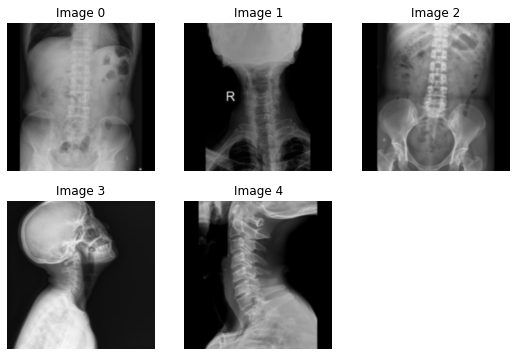

In [29]:
interp = Interpretation.from_learner(learn)
interp.plot_top_losses(5)

## Move images into folders by prediction

In [57]:
dest_folder = ROOT/'predictions'
src_folder = ROOT/'train_images'

bodyparts = df.bodypart.unique()
positions = df.position.unique()

number_of_labels_per_image = 2

for _,row in predict_df.iterrows():
    src = src_folder/row.fn
    bodypart = position =  'unknown'
    
    #Unknown
    if len(row.labels) != number_of_labels_per_image:
        os.makedirs(dest_folder/bodypart, exist_ok=True)
        dst = dest_folder/bodypart/row.fn
        
    else:
        for x in bodyparts:
            if x in row.labels:
                bodypart = x
        for x in positions:
            if x in row.labels:
                position = x

        #print(row.labels, bodypart, position)
        os.makedirs(dest_folder/bodypart, exist_ok=True)
        os.makedirs(dest_folder/bodypart/position, exist_ok=True)
        dst = dest_folder/bodypart/position/row.fn
        
    shutil.copyfile(src, dst)

